In [7]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

torch.manual_seed(0)
np.random.seed(0)

n_seq = 300
T = 20

X_list = []
y_list = []

for _ in range(n_seq):
    seq = np.random.normal(0.6, 0.1, T)  # generally normal speech
    if np.random.rand() < 0.5:
        # depressed pattern: some consecutive low-energy region
        start = np.random.randint(4, 12)
        length = np.random.randint(3, 6)
        end = min(T, start + length)
        seq[start:end] = np.random.normal(0.2, 0.05, end - start)
        label = 1
    else:
        label = 0
    X_list.append(seq)
    y_list.append(label)

X_seq = np.array(X_list, dtype=np.float32)   # (N, T)
y_seq = np.array(y_list, dtype=np.int64)     # (N,)

X_tensor = torch.tensor(X_seq).unsqueeze(-1) # (N, T, 1)
y_tensor = torch.tensor(y_seq)

# Train / test split
train_idx = int(0.7 * n_seq)
X_train = X_tensor[:train_idx]
y_train = y_tensor[:train_idx]
X_test = X_tensor[train_idx:]
y_test = y_tensor[train_idx:]


In [8]:
class BiLSTMAttn(nn.Module):
    def __init__(self, hidden_dim=16):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=1,
            hidden_size=hidden_dim,
            batch_first=True,
            bidirectional=True
        )
        self.attn = nn.Linear(hidden_dim * 2, 1)   # attention score per time step
        self.fc = nn.Linear(hidden_dim * 2, 1)     # final classifier

    def forward(self, x):
        # x: (B, T, 1)
        lstm_out, _ = self.lstm(x)                # (B, T, 2H)
        scores = self.attn(lstm_out).squeeze(-1)  # (B, T)
        attn_weights = F.softmax(scores, dim=1)   # (B, T)
        context = torch.sum(lstm_out * attn_weights.unsqueeze(-1), dim=1)  # (B, 2H)
        logits = self.fc(context).squeeze(-1)     # (B,)
        return logits, attn_weights               # we return both


In [9]:
model = BiLSTMAttn()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.BCEWithLogitsLoss()

for epoch in range(50):
    model.train()
    optimizer.zero_grad()
    logits, _ = model(X_train)
    loss = criterion(logits, y_train.float())
    loss.backward()
    optimizer.step()

model.eval()
with torch.no_grad():
    logits_test, attn_test = model(X_test)
    preds = (torch.sigmoid(logits_test) > 0.5).long()
    acc = (preds == y_test).float().mean().item()
    print("Test accuracy:", acc)


Test accuracy: 0.8666666746139526


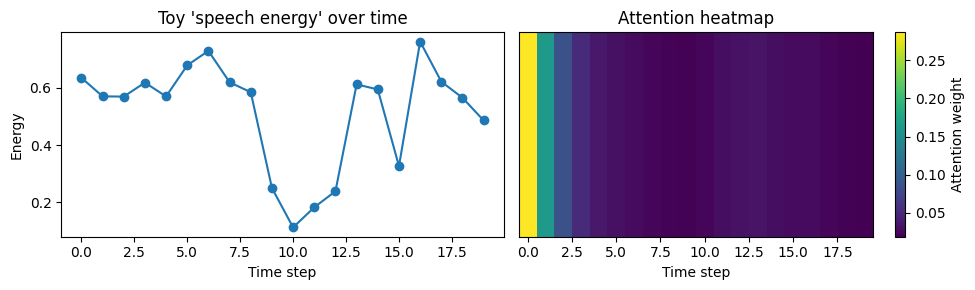

In [10]:
# pick an example
idx = 0
seq = X_test[idx].squeeze(-1).numpy()          # (T,)
with torch.no_grad():
    _, attn_w = model(X_test[idx:idx+1])
weights = attn_w[0].numpy()                    # (T,)

plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.plot(seq, marker="o")
plt.title("Toy 'speech energy' over time")
plt.xlabel("Time step")
plt.ylabel("Energy")

plt.subplot(1,2,2)
plt.imshow(weights[np.newaxis, :], aspect="auto", cmap="viridis")
plt.title("Attention heatmap")
plt.yticks([])
plt.xlabel("Time step")
plt.colorbar(label="Attention weight")
plt.tight_layout()
plt.show()


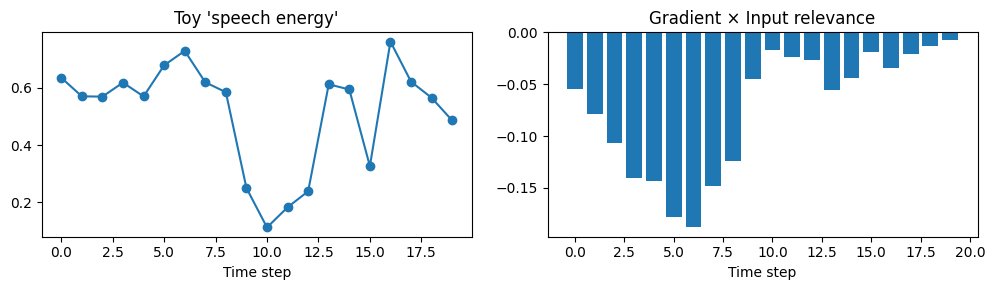

In [11]:
model.eval()

# choose one example
idx = 0
x_ex = X_test[idx:idx+1].clone()   # (1, T, 1)
x_ex.requires_grad = True

logit, _ = model(x_ex)
prob = torch.sigmoid(logit)
model.zero_grad()
prob.backward()                    # d(prob)/dx

# gradient × input
relevance = (x_ex.grad * x_ex).detach().squeeze(-1).squeeze(0).numpy()  # (T,)

seq = x_ex.detach().squeeze(-1).squeeze(0).numpy()

plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.plot(seq, marker="o")
plt.title("Toy 'speech energy'")
plt.xlabel("Time step")

plt.subplot(1,2,2)
plt.bar(np.arange(len(relevance)), relevance)
plt.title("Gradient × Input relevance")
plt.xlabel("Time step")
plt.tight_layout()
plt.show()


  0%|          | 0/30 [00:00<?, ?it/s]

shap_values shape: (30, 20)
X_shap shape: (30, 20)


C:\Users\user\AppData\Local\Temp\ipykernel_18260\3021084992.py:23: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_shap, plot_type="bar")


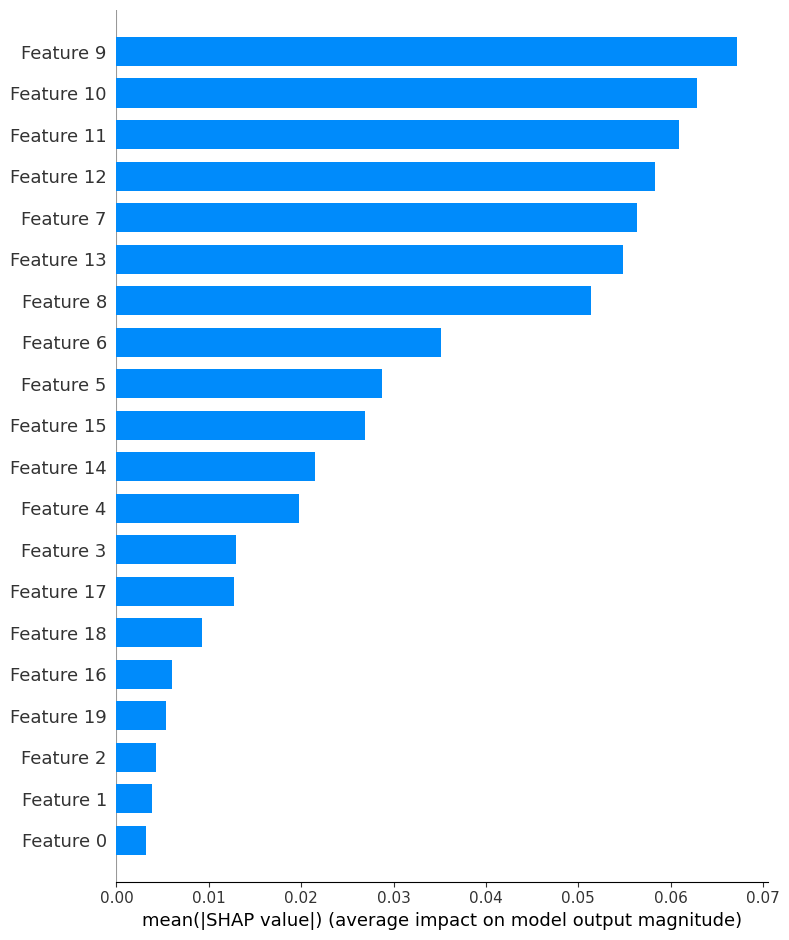

In [13]:

import shap

# 1) Wrapper: SHAP expects a function that takes numpy and returns 1D output (prob of depressed)
def model_for_shap_1d(x_np):
    x_t = torch.tensor(x_np, dtype=torch.float32).unsqueeze(-1)  # (N, T, 1)
    model.eval()
    with torch.no_grad():
        logits, _ = model(x_t)
        probs = torch.sigmoid(logits).numpy()  # (N,)
    return probs  # 1D output: probability of "depressed"

# 2) Background & subset
X_bg = X_seq[:50]                         # (N_bg, T)
X_shap = X_seq[train_idx:train_idx+30]    # (N_shap, T)

explainer = shap.KernelExplainer(model_for_shap_1d, X_bg)
shap_values = explainer.shap_values(X_shap, nsamples=100)  # now shap_values is (N_shap, T)

print("shap_values shape:", np.array(shap_values).shape)
print("X_shap shape:", X_shap.shape)

# 3) Global importance over time steps
shap.summary_plot(shap_values, X_shap, plot_type="bar")


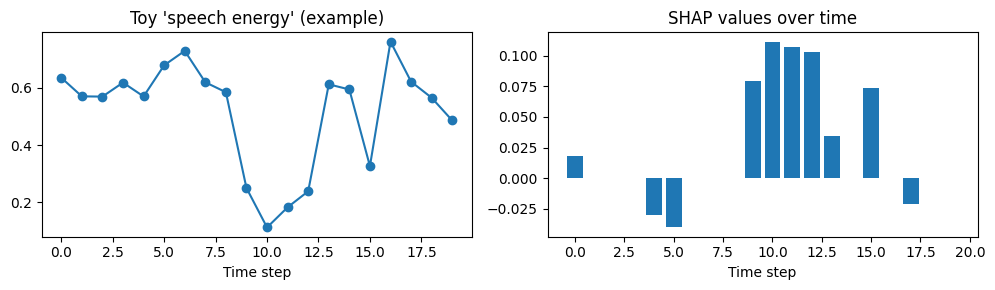

In [15]:
idx_ex = 0
shap_vals_ex = shap_values[idx_ex]    # (T,)  <-- correct now
seq_ex = X_shap[idx_ex]               # (T,)

plt.figure(figsize=(10,3))

plt.subplot(1,2,1)
plt.plot(seq_ex, marker="o")
plt.title("Toy 'speech energy' (example)")
plt.xlabel("Time step")

plt.subplot(1,2,2)
plt.bar(np.arange(len(shap_vals_ex)), shap_vals_ex)
plt.title("SHAP values over time")
plt.xlabel("Time step")

plt.tight_layout()
plt.show()
